In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, Model, Input
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, cohen_kappa_score, balanced_accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import SMOTE

In [2]:
all_draft_data = pd.read_csv('../data/2025/all_draft_data.csv')
all_draft_data.head()

,pick_no,round,scoring_type,qb_need,rb_need,wr_need,te_need,k_need,dst_need,flex_need,...,dst_available,flex_available,qb_vor,rb_vor,wr_vor,te_vor,k_vor,flex_vor,position_drafted,draft_id
0,1,1,0.0,1,2,2,1,1,1,2,...,32,151,69.0,164.0,125.0,68.0,17.0,164.0,WR,1224007842931937280
1,2,1,0.0,1,2,2,1,1,1,2,...,32,150,69.0,164.0,116.0,68.0,17.0,164.0,WR,1224007842931937280
2,3,1,0.0,1,2,2,1,1,1,2,...,32,149,69.0,164.0,116.0,68.0,17.0,164.0,RB,1224007842931937280
3,4,1,0.0,1,2,2,1,1,1,2,...,32,148,69.0,154.0,116.0,68.0,17.0,154.0,RB,1224007842931937280
4,5,1,0.0,1,2,2,1,1,1,2,...,32,147,69.0,154.0,116.0,68.0,17.0,154.0,WR,1224007842931937280


In [30]:
draft_data = all_draft_data[~all_draft_data['round'].isin([14, 15])].copy()

draft_data.drop(columns=['k_need','k_available','k_vor','other_k_need','dst_available','dst_need','other_dst_need'            ], inplace=True)
draft_data.drop(columns=['draft_id'], inplace=True)
draft_data.drop(columns=['scoring_type'], inplace=True)
#draft_data.drop(columns=['pick_no'], inplace=True)
#draft_data.drop(columns=['qb_need', 'other_qb_need', 'qb_vor', 'qb_available'], inplace=True)
#draft_data.drop(columns=['te_need', 'other_te_need', 'te_vor', 'te_available'], inplace=True)
#draft_data.drop(columns=['other_qb_need', 'other_rb_need', 'other_wr_need', 'other_te_need', 'other_flex_need'], inplace=True)
#draft_data.drop(columns=['qb_available', 'rb_available', 'wr_available', 'te_available', 'flex_available'], inplace=True)
#draft_data = draft_data[~draft_data['position_drafted'].isin(['QB', 'TE'])].copy()

bounded_cols = [
    'pick_no','round',
    'qb_need', 'rb_need', 'wr_need', 'te_need', 'flex_need',
   'other_qb_need', 'other_rb_need', 'other_wr_need', 'other_te_need', 'other_flex_need',
    'qb_available', 'rb_available', 'wr_available', 'te_available', 'flex_available'
]
vor_cols = ['qb_vor', 'rb_vor', 'wr_vor', 'te_vor', 'flex_vor']

draft_data[bounded_cols + vor_cols] = draft_data[bounded_cols + vor_cols].astype(float)

minmax_scaler = MinMaxScaler()
draft_data[bounded_cols] = minmax_scaler.fit_transform(draft_data[bounded_cols])

std_scaler = StandardScaler()
draft_data[vor_cols] = std_scaler.fit_transform(draft_data[vor_cols])

#draft_data.drop(columns=['flex_vor', 'other_flex_need', 'flex_available','flex_need'], inplace=True)

le = LabelEncoder()
draft_data['position_drafted_encoded'] = le.fit_transform(draft_data['position_drafted'])

In [31]:
draft_data.head()

,pick_no,round,qb_need,rb_need,wr_need,te_need,flex_need,other_qb_need,other_rb_need,other_wr_need,...,wr_available,te_available,flex_available,qb_vor,rb_vor,wr_vor,te_vor,flex_vor,position_drafted,position_drafted_encoded
0,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.000000,1.0,1.000000,1.32178,1.851562,1.754548,0.381691,1.840784,WR,3
1,0.007752,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.944444,...,0.979167,1.0,0.989899,1.32178,1.851562,1.434085,0.381691,1.840784,WR,3
2,0.015504,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.888889,...,0.958333,1.0,0.979798,1.32178,1.851562,1.434085,0.381691,1.840784,RB,1
3,0.023256,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.944444,0.888889,...,0.958333,1.0,0.969697,1.32178,1.591117,1.434085,0.381691,1.580863,RB,1
4,0.031008,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.888889,0.888889,...,0.958333,1.0,0.959596,1.32178,1.591117,1.434085,0.381691,1.580863,WR,3


In [32]:
train_val, test = train_test_split(draft_data, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)
X_train = train.drop(columns=[ 'position_drafted','position_drafted_encoded'])
y_train = train['position_drafted_encoded']
X_val = val.drop(columns=['position_drafted','position_drafted_encoded'])
y_val = val['position_drafted_encoded']
X_test = test.drop(columns=[ 'position_drafted','position_drafted_encoded'])
y_test = test['position_drafted_encoded']


In [33]:
y_train = le.transform(train['position_drafted'])
y_val = le.transform(val['position_drafted'])
y_test = le.transform(test['position_drafted'])
position_mapping = dict(enumerate(le.classes_))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(position_mapping)

{0: 'QB', 1: 'RB', 2: 'TE', 3: 'WR'}


In [34]:
print(f"X Train Shape: {X_train.shape}")
print(f"X Test Shape: {X_test.shape}")
print(f"X Val Shape: {X_val.shape}")
print(f"y Train Shape: {y_train.shape}")
print(f"y Test Shape: {y_test.shape}")
print(f"y Val Shape: {y_val.shape}")

X Train Shape: (3892, 22)
X Test Shape: (780, 22)
X Val Shape: (780, 22)
y Train Shape: (3892,)
y Test Shape: (780,)
y Val Shape: (780,)


In [35]:
class_counts = pd.Series(y_train).value_counts()
print(class_counts)

1    973
2    973
3    973
0    973
Name: count, dtype: int64


In [36]:
from tensorflow.keras import layers, Model, Input

inputs = Input(shape=(X_train.shape[1],))

x1 = layers.Dense(1028)(inputs)
x1 = layers.LeakyReLU()(x1)
x1 = layers.LayerNormalization()(x1)
x1 = layers.Dropout(0.2)(x1)

x2 = layers.Dense(512)(x1)
x2 = layers.LeakyReLU()(x2)
x2 = layers.LayerNormalization()(x2)
x2 = layers.Dropout(0.2)(x2)

x3 = layers.Dense(256)(x2)
x3 = layers.LeakyReLU()(x3)
x3 = layers.LayerNormalization()(x3)
x3 = layers.Dropout(0.2)(x3)

x4 = layers.Dense(128)(x3)
x4 = layers.LeakyReLU()(x4)
x4 = layers.LayerNormalization()(x4)
x4 = layers.Dropout(0.2)(x4)

concat = layers.Concatenate()([inputs, x1, x2, x3, x4])

outputs = layers.Dense(len(position_mapping), activation='softmax')(concat)

model = Model(inputs, outputs)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [37]:
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/40
119/122 [============================>.] - ETA: 0s - loss: 1.5176 - accuracy: 0.4086
Epoch 1: val_loss improved from inf to 1.64146, saving model to best_model.weights.h5
122/122 [==============================] - 2s 9ms/step - loss: 1.5119 - accuracy: 0.4085 - val_loss: 1.6415 - val_accuracy: 0.4038
Epoch 2/40
116/122 [===========================>..] - ETA: 0s - loss: 1.2924 - accuracy: 0.4491
Epoch 2: val_loss improved from 1.64146 to 1.20022, saving model to best_model.weights.h5
122/122 [==============================] - 1s 8ms/step - loss: 1.2892 - accuracy: 0.4496 - val_loss: 1.2002 - val_accuracy: 0.4141
Epoch 3/40
121/122 [============================>.] - ETA: 0s - loss: 1.2224 - accuracy: 0.4576
Epoch 3: val_loss improved from 1.20022 to 1.18823, saving model to best_model.weights.h5
122/122 [==============================] - 1s 8ms/step - loss: 1.2222 - accuracy: 0.4579 - val_loss: 1.1882 - val_accuracy: 0.4423
Epoch 4/40
119/122 [============================>.] -

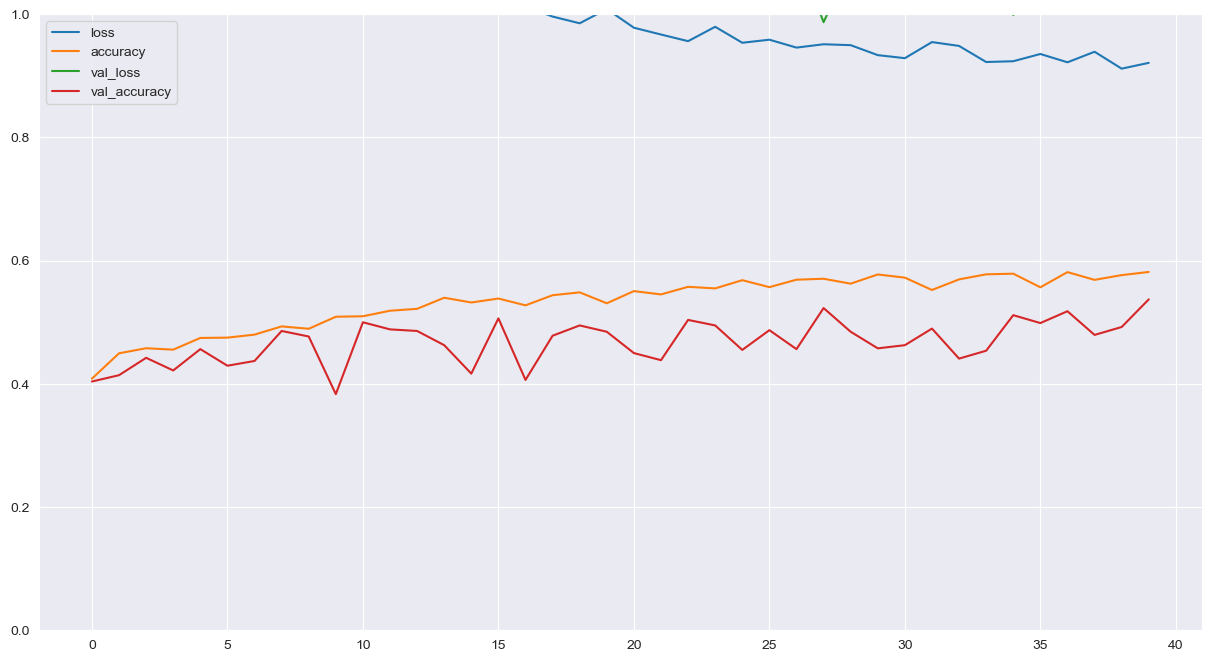

In [38]:
pd.DataFrame(history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [39]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)


# y_test: true labels, y_pred_labels: predicted labels
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_labels))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_labels))

25/25 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

          QB       0.49      0.79      0.61       117
          RB       0.50      0.40      0.45       285
          TE       0.44      0.39      0.41        85
          WR       0.55      0.54      0.54       293

    accuracy                           0.51       780
   macro avg       0.50      0.53      0.50       780
weighted avg       0.51      0.51      0.50       780

Cohen's Kappa: 0.30977619636005527
Balanced Accuracy: 0.5314662519192364


In [40]:
print(pd.Series(draft_data['position_drafted_encoded']).value_counts())
for idx, label in enumerate(le.classes_):
    print(f"{label}: {idx}")

position_drafted_encoded
3    1581
1    1285
0     584
2     450
Name: count, dtype: int64
QB: 0
RB: 1
TE: 2
WR: 3


In [41]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
print("Validation accuracy:", xgb_model.score(X_val, y_val))

Validation accuracy: 0.5474358974358975


In [42]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Validation accuracy:", rf.score(X_val, y_val))

Validation accuracy: 0.514102564102564
